# Import essential libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import pyLDAvis.sklearn

In [2]:
def lemma_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [3]:
main_df = pd.read_csv('NYT2000_1.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
temp_df = pd.read_csv('NYT2000_2.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
main_df = pd.concat([main_df,temp_df], ignore_index=True)

In [4]:
# Remove NaN values, lowercase contents of Body column, filters for bush and gore and resets the index
print(main_df.shape)
main_df.dropna(subset=['Body'], inplace=True)
print(main_df.shape)

main_df['Body'] = main_df['Body'].str.lower()
main_df = main_df[main_df['Body'].str.contains('gore|bush')]
main_df = main_df.reset_index(drop=True)

(50130, 4)
(49471, 4)


In [5]:
# Create a single date column from day, month and year columns
main_df['Date'] = pd.to_datetime(
    main_df['Publication Year'] * 10000 + main_df['Publication Month'] * 100 + main_df['Publication Day Of Month'],
    format='%Y%m%d')
main_df.drop(['Publication Year', 'Publication Month', 'Publication Day Of Month'], axis=1, inplace=True)
print(main_df.shape)

(4706, 2)


In [6]:
# Remove unnecessary symbols, numbers, words less than 3 characters and apply lemmatizer
main_df['Body'].replace([r'[,\.!?]', r'\d+', r'\b(\w{1,2})\b'], '', inplace=True, regex=True)
main_df['Body'].apply(lemma_text)
main_df['Body'] = main_df['Body'].str.replace('said', '', regex=False)
print(main_df['Body'].head(10))

0    just before the july  recess  senate committee...
1    george  bush -- pittsburgh and east brunswick ...
2    drivers have been paying almost twice  much fo...
3    for farmers the months leading  harvest time a...
4    international -  and vietnam reach broad trade...
5    dna test fails  exonerate prisoner given stay ...
6    former senator bill bradley made  official tod...
7    from his opening salutation ''   member  the n...
8    the democratic national committee' new televis...
9    several homeowners cell phones  hand tend thei...
Name: Body, dtype: object


In [7]:
# Generate doc-term matrix
cv = CountVectorizer(stop_words='english', max_df=3500)
ft_cv = cv.fit_transform(main_df['Body'])
vocabulary = cv.get_feature_names()

doc_term_matrix = pd.DataFrame(ft_cv.toarray(), columns=vocabulary)
print(doc_term_matrix.shape)

(4706, 63104)


In [8]:
# Fit LDA model to doc-term matrix
k = 15
lda = LatentDirichletAllocation(n_components=k)

lda.fit(ft_cv)

print('log likelihood score, 15 topics: ' + str(lda.score(ft_cv)))
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda, ft_cv, cv)
pyLDAvis.display(p)

log likelihood score, 15 topics: -17595303.209074326


(4706, 16)
(194, 15)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  3.292821  0.002974  1.050363  0.112404  0.371362  0.536799   
2000-05-02  1.765738  0.009597  0.009597  0.145324  0.044345  1.009437   
2000-05-03  0.902314  0.816356  0.435736  0.511087  1.571983  0.939420   
2000-05-04  2.223121  0.594953  0.630881  0.082867  1.046698  1.242689   
2000-05-05  3.962823  0.011935  0.011935  0.011935  2.200033  0.603215   
2000-05-06  1.034343  0.010469  0.010469  0.140205  1.708525  1.126522   
2000-05-07  2.697649  0.183088  0.234698  1.152815  1.939744  0.326671   
2000-05-08  1.288939  0.003580  0.023513  0.319110  0.516023  0.249453   
2000-05-09  1.467267  0.012872  0.102878  0.012872  2.649617  1.426731   
2000-05-10  2.720141  0.009105  0.542354  0.032305  0.606818  1.275875   

                  6         7         8         9         10        11  \
Date            

<Figure size 1152x720 with 0 Axes>

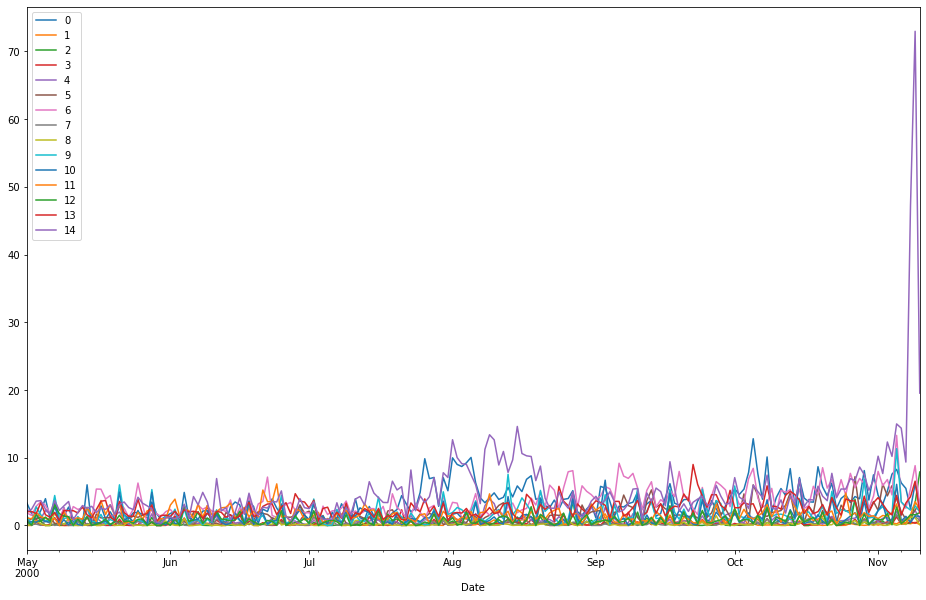

In [16]:
# Generate doc-topic matrix
lda_out = lda.transform(ft_cv)
doc_topic_matrix = pd.DataFrame(lda_out)
doc_topic_matrix['Date'] = main_df['Date']
print(doc_topic_matrix.shape)

aggregator = {i: 'sum' for i in range(k)}
coverage_curve = doc_topic_matrix.groupby(['Date']).agg(aggregator)
print(coverage_curve.shape)
print(coverage_curve.head(10))

plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()
coverage_curve.plot()
plt.show()

In [10]:
#Read the IEM data and Normalize one of the stocks
iem_data = pd.read_excel('IEM2000.xlsx')
iem_data.drop(['Units', '$Volume', 'LowPrice','HighPrice','AvgPrice'], axis=1, inplace=True)

dem_data = iem_data[iem_data['Contract'].str.contains('Dem')]
rep_data = iem_data[iem_data['Contract'].str.contains('Rep')]

dem_data.set_index('Date', inplace=True)
rep_data.set_index('Date', inplace=True)

dem_data['NormLastPrice'] = dem_data['LastPrice'] / (dem_data['LastPrice'] + rep_data['LastPrice'])
dem_data.drop(['LastPrice', 'Contract'], axis=1, inplace=True)

print(dem_data.head())

            NormLastPrice
Date                     
2000-05-01       0.523810
2000-05-02       0.504970
2000-05-03       0.509491
2000-05-04       0.511466
2000-05-05       0.520875


C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
<ipython-input-10-7b4d2e914db2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [14]:
combined_data = pd.concat([dem_data, coverage_curve], axis=1, join='inner')
print(combined_data.head())
print(combined_data.tail())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_data.index))


            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  3.292821  0.002974  1.050363  0.112404  0.371362   
2000-05-02       0.504970  1.765738  0.009597  0.009597  0.145324  0.044345   
2000-05-03       0.509491  0.902314  0.816356  0.435736  0.511087  1.571983   
2000-05-04       0.511466  2.223121  0.594953  0.630881  0.082867  1.046698   
2000-05-05       0.520875  3.962823  0.011935  0.011935  0.011935  2.200033   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.536799  1.846363  0.054398  0.002974  1.426490  0.416843   
2000-05-02  1.009437  1.497277  0.153629  0.137626  0.147746  0.565446   
2000-05-03  0.939420  2.853727  0.205119  0.643351  2.755820  0.501650   
2000-05-04  1.242689  3.510898  0.014654  0.235907  1.583377  0.849780   
20

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_results1 = grangercausalitytests(combined_data[['NormLastPrice',2]],5)
granger_results2 = grangercausalitytests(combined_data[['NormLastPrice',7]],5)
granger_results3 = grangercausalitytests(combined_data[['NormLastPrice',10]],5)
granger_results4 = grangercausalitytests(combined_data[['NormLastPrice',11]],5)
granger_results5 = grangercausalitytests(combined_data[['NormLastPrice',12]],5)

C:\Users\JHuamani\Anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3151  , p=0.5752  , df_denom=190, df_num=1
ssr based chi2 test:   chi2=0.3201  , p=0.5716  , df=1
likelihood ratio test: chi2=0.3198  , p=0.5717  , df=1
parameter F test:         F=0.3151  , p=0.5752  , df_denom=190, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1736  , p=0.8408  , df_denom=187, df_num=2
ssr based chi2 test:   chi2=0.3564  , p=0.8368  , df=2
likelihood ratio test: chi2=0.3561  , p=0.8369  , df=2
parameter F test:         F=0.1736  , p=0.8408  , df_denom=187, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6390  , p=0.5908  , df_denom=184, df_num=3
ssr based chi2 test:   chi2=1.9899  , p=0.5745  , df=3
likelihood ratio test: chi2=1.9796  , p=0.5766  , df=3
parameter F test:         F=0.6390  , p=0.5908  , df_denom=184, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6302  , p=0.6416  